# Testings with Random forest regressor </br>
This notebook has all testings done with the random forest regression to inspect if this model fits for the weekly rental prediction with the given predictors. The training accuracy and testing accuracy of the random forest regression are also included in this notebook. 

In [1]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder

### Merge all data collected from 2013 - 2022

In [2]:
path = r'../data/curated/merged_dataset/'
all_files = glob.glob(os.path.join(path , "*.csv"))

li = []

for filename in sorted(all_files):
    df = pd.read_csv(filename, index_col=None, header=0)
    li.append(df)

merged_df = pd.concat(li, axis=0, ignore_index=True)

# Rename the columns to facilitate to call them for later
merged_df.rename({'gdp(USD Millioins)': 'gdp', 'saving_rate(% of GDP)': 'saving_rate'}, axis=1, inplace=True)

LOG_FEATURES = ['saving_rate', 'min_distance_to_prim', 
'min_distance_to_poli', 'min_distance_to_park', 'min_distance_to_second', 'min_distance_to_hosp', 'min_distance_to_cbd', 
'min_distance_to_shop', 'population_density', 'income_per_person', 
'crime_cases', 'min_distance_to_train', 'gdp']

all_candidates = LOG_FEATURES.copy()
for log_feature in LOG_FEATURES:
    merged_df[log_feature] = np.log(merged_df[log_feature])

merged_df['weekly_rent'] = np.log(merged_df['weekly_rent'])

categorical_features = ['nbed', 'nbath', 'ncar', 'residence_type', 'sa2_2021']
le = LabelEncoder()

# Convert the categorical variables to numerical
for i in range(len(categorical_features)):
    new = le.fit_transform(merged_df[categorical_features[i]])
    merged_df[categorical_features[i]] = new

#merged_df = pd.get_dummies(data=merged_df, columns=['nbed'], prefix='nbed')
#merged_df = pd.get_dummies(data=merged_df, columns=['nbath'], prefix='nbath')
#merged_df = pd.get_dummies(data=merged_df, columns=['ncar'], prefix='ncar')
#merged_df = pd.get_dummies(data=merged_df, columns=['sa2_2021'], prefix='sa2')
#merged_df = pd.get_dummies(data=merged_df, columns=['residence_type'], prefix='resiType') 
merged_df.drop(['address', 'latitude', 'longitude', 'postcode', 'sa2_2016'], axis=1, inplace=True)

# Check the merged dataframe
merged_df

,year,sa2_2021,residence_type,nbed,nbath,ncar,min_distance_to_cbd,min_distance_to_park,min_distance_to_prim,min_distance_to_second,min_distance_to_train,min_distance_to_hosp,min_distance_to_poli,min_distance_to_shop,weekly_rent,gdp,saving_rate,income_per_person,population_density,crime_cases
0,2013,61,1,1,0,0,5.429221,3.142442,1.995716,2.831157,3.571453,3.061063,3.093158,2.235600,5.703782,14.244988,1.925910,10.588692,0.775836,4.454347
1,2013,102,1,1,0,0,5.410131,1.743518,1.872626,1.912197,2.020693,2.005488,1.837652,2.235600,5.370638,14.244988,1.925910,10.762630,1.691111,3.583519
2,2013,61,1,1,0,0,5.494118,1.631634,-1.608089,3.603350,3.928947,3.601015,-2.467696,2.235600,5.164786,14.244988,1.925910,10.588692,0.775836,4.454347
3,2013,23,1,5,2,0,4.944198,4.360868,2.366989,2.478133,2.422061,5.178674,4.436437,2.235600,5.857933,14.244988,1.925910,10.681809,6.160712,7.160846
4,2013,209,0,0,0,0,2.629104,-0.069886,0.284660,1.250400,0.792087,5.178674,4.436437,1.377508,5.616771,14.244988,1.925910,11.363304,7.949519,7.561642
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
172030,2022,89,1,3,0,1,5.681130,-0.579604,0.197284,4.742932,4.500764,4.945698,4.308865,2.613681,5.579730,15.011175,2.552487,10.903481,5.996452,5.638355
172031,2022,504,1,3,2,2,5.554087,1.250151,1.626702,1.282516,2.124875,0.956711,4.308865,2.613681,6.214608,15.011175,2.552487,11.015813,6.535241,8.022569
172032,2022,190,1,1,2,1,2.248210,0.896133,0.292155,0.484412,1.290034,4.945698,4.308865,0.681257,6.620073,15.011175,2.552487,11.500412,8.204125,6.632002
172033,2022,133,0,0,0,1,0.614823,-0.427726,0.099284,0.246391,0.630420,4.945698,4.308865,2.613681,6.013715,15.011175,2.552487,11.174728,8.664060,7.488853


### Preprocess for training dataset

In [3]:
# Convert the numbers read as string to floats and integers
"""for col in merged_df.columns:
    if 'resiType' in col:
        merged_df[col] = merged_df[col].astype(int)
    elif 'year' in col:
        merged_df[col] = merged_df[col].astype(int)
    elif 'sa2' in col:
        merged_df[col] = merged_df[col].astype(int)
    elif 'nbed' in col:
        merged_df[col] = merged_df[col].astype(int)
    elif 'nbath' in col:
        merged_df[col] = merged_df[col].astype(int)
    elif 'ncar' in col:
        merged_df[col] = merged_df[col].astype(int)
    else:
        merged_df[col] = merged_df[col].astype(float)

"""
# Drop Nans
merged_df.dropna(inplace=True)

# Log transformatoin on our target class for better performance 
y = np.log(merged_df['weekly_rent'])

# Assign predictor data to X for training purposes
X = merged_df.drop('weekly_rent', axis=1)

print(y)
print(X)


0         1.741130
1         1.680947
2         1.641864
3         1.767797
4         1.725757
            ...   
172030    1.719140
172031    1.826903
172032    1.890106
172033    1.794043
172034    1.774935
Name: weekly_rent, Length: 172018, dtype: float64
        year  sa2_2021  residence_type  nbed  nbath  ncar  \
0       2013        61               1     1      0     0   
1       2013       102               1     1      0     0   
2       2013        61               1     1      0     0   
3       2013        23               1     5      2     0   
4       2013       209               0     0      0     0   
...      ...       ...             ...   ...    ...   ...   
172030  2022        89               1     3      0     1   
172031  2022       504               1     3      2     2   
172032  2022       190               1     1      2     1   
172033  2022       133               0     0      0     1   
172034  2022       149               0     0      0     1   

        

### Train the model with the tranining dataset completed from the above cell

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.3, random_state= 42)
X_null = X_train.drop(LOG_FEATURES, axis=1) # By default, all categorical variables are used
# Train the model with the training dataset
sel = RandomForestRegressor(n_estimators = 30, random_state=42)
sel.fit(X_null, y_train)
predict_null = sel.predict(X_null)
print(f'Null Training R2 = {r2_score(y_train, predict_null)}')
print(f'Null Training MSE = {mean_squared_error(y_train, predict_null)}')
# Get the names of features selected
sel.feature_importances_

Null Training R2 = 0.8132887041534328
Null Training MSE = 0.0007420484717707479


array([0.12770439, 0.49581624, 0.01403128, 0.10881506, 0.19834123,
       0.0552918 ])

In [7]:
mse_dict = {}
last_min = mean_squared_error(y_train, predict_null)
candidates = []

while(True):
    for x in all_candidates:
        print(f"trying feature {x}")
        new_X = X_train[x]
        forward_X = pd.concat([new_X, X_null], axis=1)
        model = RandomForestRegressor(n_estimators = 30, random_state=42).fit(forward_X, y_train)
        temp_predict = model.predict(forward_X)
        mse_dict[x] = mean_squared_error(y_train, temp_predict)
        print(f"Training mse = {mean_squared_error(y_train, temp_predict)}")

    min_mse =  min(mse_dict.values())
    min_mse_key = min(mse_dict, key=mse_dict.get)

    if min_mse < last_min:
        candidates.append(min_mse_key)
        all_candidates.remove(min_mse_key)
        last_min = min_mse
        X_null = pd.concat([X_train[min_mse_key], X_null], axis=1)

        print('step: ' + str(len(candidates)))
        print(candidates)
        print('new Training mse: ' + str(min_mse))
        print('===============')
    else:
        model = RandomForestRegressor(n_estimators = 30, random_state=42).fit(X_null, y_train)
        final_prediction = model.predict(X_null)
        r2 = r2_score(y_train, final_prediction)
        mse = mean_squared_error(y_train, final_prediction)
        print(f"Selected Model R2 = {r2}, MSE = {mse}")
        break

trying feature saving_rate
Training mse = 0.000742209938565185
trying feature min_distance_to_prim
Training mse = 0.00019783878328227686
trying feature min_distance_to_poli
Training mse = 0.00044169911607891974
trying feature min_distance_to_park
Training mse = 0.00023507633812871277
trying feature min_distance_to_second
Training mse = 0.0002908125405920134
trying feature min_distance_to_hosp
Training mse = 0.0005716501987192399
trying feature min_distance_to_cbd
Training mse = 0.00018203509909601014
trying feature min_distance_to_shop
Training mse = 0.0006694917111646209
trying feature population_density
Training mse = 0.0007408469566444419
trying feature income_per_person
Training mse = 0.0007432440242794966
trying feature crime_cases
Training mse = 0.0006671275417631461
trying feature min_distance_to_train
Training mse = 0.00037281724887791194
trying feature gdp
Training mse = 0.0007418059653617981
step: 1
['min_distance_to_cbd']
new Training mse: 0.00018203509909601014
trying featu

In [8]:
SELECTED_FEATURES = set(candidates)
sorted(SELECTED_FEATURES)

['min_distance_to_cbd',
 'min_distance_to_hosp',
 'min_distance_to_park',
 'min_distance_to_prim',
 'min_distance_to_second',
 'min_distance_to_train']

In [11]:
drop = list(set(LOG_FEATURES) - SELECTED_FEATURES)
final_model = RandomForestRegressor(n_estimators = 30, random_state=42).fit(X_train.drop(drop, axis=1), y_train)
test_prediction = final_model.predict(X_test.drop(drop, axis=1))
test_r2 = r2_score(y_test, test_prediction)
test_mse = mean_squared_error(y_test, test_prediction)
print(f"Testing R2 = {test_r2}, MSE = {test_mse}")

Testing R2 = 0.7433016487584002, MSE = 0.00101484002398268


### Make a sorted dictionary with the feature importances calculated from the above cell 


In [14]:
final_model.feature_importances_

array([0.0797243 , 0.10193845, 0.00709198, 0.09029276, 0.16663654,
       0.02183489, 0.29862025, 0.05351113, 0.05863437, 0.04797244,
       0.04443141, 0.02931148])

In [15]:
dict = {}

for i in range(len(X.drop(drop, axis=1).columns)):
    dict[X.columns[i]] = final_model.feature_importances_[i]

# Sort the dictinary keys by the values (feature importance values)
sorted_dict = sorted(dict.items(), key=lambda x:x[1])

# Extract information to visualize the features with their importance values
keys = []
vals = []
for i in sorted_dict:
    keys.append(i[0])
    vals.append(i[1])

print(keys, vals)

['residence_type', 'ncar', 'min_distance_to_hosp', 'min_distance_to_train', 'min_distance_to_second', 'min_distance_to_park', 'min_distance_to_prim', 'year', 'nbed', 'sa2_2021', 'nbath', 'min_distance_to_cbd'] [0.007091978310186066, 0.021834887143338616, 0.029311479638634865, 0.044431408131417396, 0.04797244401501087, 0.05351113107605929, 0.05863437153024891, 0.07972429947354501, 0.09029276120361446, 0.10193844897302957, 0.166636539814768, 0.2986202506901468]


### Visualize the data by using the sorted dictionary

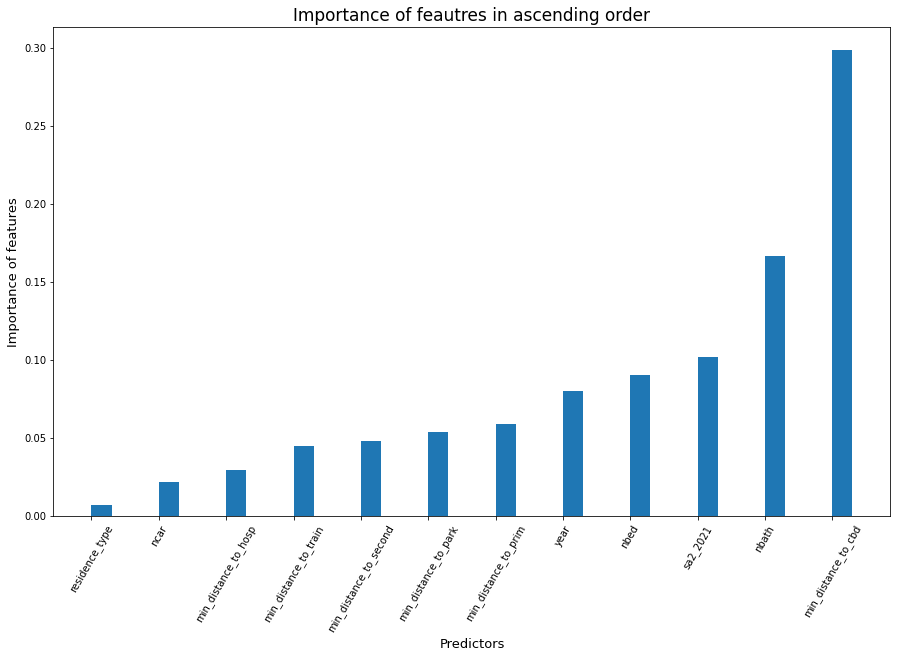

In [16]:
to_graph_keys = keys[-21:]
to_graph_vals = vals[-21:]

plt.figure(figsize=(15, 9)) 
plt.bar(to_graph_keys, to_graph_vals, align='edge', width=0.3)
plt.xticks(rotation=60)
plt.ylabel("Importance of features", fontsize = 13)
plt.xlabel("Predictors", fontsize = 13)
plt.title("Importance of feautres in ascending order", fontsize = 17)
plt.show()

Please note, the graph above is showing the last 21 predictors from the feature importance function, which mean the top 21 predictors with the highest importance values. All the front features, not shown on the graph, are ignored because they are all SA2 codes converted into dummy variables and from the graph, we want to get an idea of what kind of other features are significant to predict the weekly rental price. </br>
As found above, the most important feature is 'income per person' and the least important feature is residence_type according to the random forest regressor. The values of how important / significant features are computed with the mean and standard deviation of accumulation of the impurity decrease (which means to have stronger sign to predict the target class, weekly_rent) within each tree. </br>
It is interesting that the residence type was not ranked in a higher positino in the feature importance. Since most of our rental property data are categorized under 'house', this may have caused the lowest importance value because under 'house' it has a big range of rental prices. This is a possible limitation about our raw data since we categorized all different kinds of house such as villa or townhouse under 'house' from our team's assumption that customers might want simpler choices given (which are house vs apartment) when they select the property they prefer when using our website. </br>
The other interesitng finding is the predictors do not really seem to have huge contributions. It may indicate that our attributes may not direct factors to predict weekly_rent. Otherwise, it might be caused from our data collection method since the data for each predictor was not able to get collected from one source, hence they are coming from all difference resources and also were labelled with different area granualrities (SA2_2016, SA2_2021, postcodes etc).

Since the predictors all have feature importances lower than 30%, it was hard to choose what features to drop from the input dataset of our prediction model. Therefore, PCA feature selection was also implemented to see how many predictors we need to put into our final model to predict the weekly_rent price. Not surprisingly, the result showed when we have most of the features, we can have the maximum explained variance. We could have dropped some of the features where the explained variance reaches around 80%, but since all of our predictors are not strong enough to predict weekly rental prices, we put them all hoping that they will still support each other to make a clearer prediction. 

### Training accuracy and Testing accuracy of Random Forest Regressor

In [21]:
# Check the accuracy before predicting with the trained random forest regressor
r2 = final_model.score(X_test.drop(drop, axis=1), y_test)
print('Testing R2:', round(r2, 2)*100, '%.')

Testing R2: 74.0 %.


In [22]:
# Training accruacy
r2 = final_model.score(X_train.drop(drop, axis=1), y_train)
print('Training R2:', round(r2, 2)*100, '%.')

Training R2: 96.0 %.


The computed training R squared is around 96% while the testing is approximately 74%. This is qute reasonable results because the training one is predicting the weekly rent from the dataset that they have been trained on. 